
Code to import files from drive


In [2]:
! pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
upload = drive.CreateFile({'id': '1jcE4BMo1-uS_ZbRrRyQfevMLX1UCGP6g'})
upload.GetContentFile('respiban_a.csv')

upload = drive.CreateFile({'id': '1kJp0aSQszAM32p6sgeuVtwAU9W3Yp5IX'})
upload.GetContentFile('respiban_b.csv')

In [2]:
import pandas as pd

respiban_a = pd.read_csv("respiban_a.csv")
respiban_b = pd.read_csv("respiban_b.csv")
respibans = pd.concat([respiban_a, respiban_b], axis=1).reindex(respiban_a.index).drop(columns=["Unnamed: 0"]).reset_index()

respibans.head()

,index,ECG,EMG,EDA,Temp,Resp,Condition
0,0,0.021423,-0.004440,5.250549,30.120758,-1.148987,0
1,1,0.020325,0.004349,5.267334,30.129517,-1.124573,0
2,2,0.016525,0.005173,5.243301,30.138214,-1.152039,0
3,3,0.016708,0.007187,5.249405,30.129517,-1.158142,0
4,4,0.011673,-0.015152,5.286407,30.130951,-1.161194,0


In [3]:
#Original authors said to disregard conditions 5-7 ; dropping them

respiban = respibans[respibans['Condition'] <= 4]
len(respiban)

59125500


Model 1: All categories


In [12]:
from numpy.random import seed
seed(1)

import numpy as np

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [71]:
#After training a model on 5,000,000 rows of the original dataset, it appears that beyond 500,000 rows, accuracy may not improve.

respiban_mini = respiban.sample(n=600000, random_state=1)

X = respiban_mini.drop("Condition", axis=1)
y = respiban_mini["Condition"]
print(X.shape, y.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# scaling X (physiological data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# One-hot-encoding y to avoid magnitude effects
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

(600000, 6) (600000,)


In [72]:
#Building model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=12, activation='relu', input_dim=6))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

In [73]:
#Running model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [74]:
history_a = model.fit(
    X_test_scaled,
    y_test_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [97]:
model_loss, model_accuracy = model.evaluate(
    X_train_scaled, y_train_categorical, verbose=2)
print(
    f"Training - Loss: {model_loss}, Accuracy: {model_accuracy}")

model_loss2, model_accuracy2 = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Testing - Loss: {model_loss2}, Accuracy: {model_accuracy2}")

14063/14063 - 11s - loss: 0.5359 - accuracy: 0.7677
Training - Loss: 0.53594571352005, Accuracy: 0.7677111029624939
4688/4688 - 4s - loss: 0.5376 - accuracy: 0.7678
Testing - Loss: 0.537642240524292, Accuracy: 0.7678466439247131


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

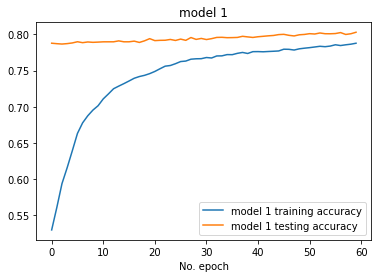

In [83]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='model 1 training accuracy')
plt.plot(history_a.history['accuracy'], label='model 1 testing accuracy')
plt.title('model 1')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
fig1 = plt.gcf()
fig1.savefig("model1.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("model1.png")
plt.show()

Model 2: Baseline vs meditation

In [76]:
respiban2 = respibans[respibans['Condition'].isin(["1","4"])]
respiban2_mini = respiban2.sample(n=600000, random_state=1)

Xa = respiban2_mini.drop("Condition", axis=1)
ya = respiban2_mini["Condition"]
print(Xa.shape, ya.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# scaling X (physiological data)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(
    Xa, ya, random_state=1)
Xa_scaler = MinMaxScaler().fit(Xa_train)
Xa_train_scaled = Xa_scaler.transform(Xa_train)
Xa_test_scaled = Xa_scaler.transform(Xa_test)

# One-hot-encoding y to avoid magnitude effects
ya_train_categorical = to_categorical(ya_train)
ya_test_categorical = to_categorical(ya_test)

(600000, 6) (600000,)


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model2 = Sequential()
model2.add(Dense(units=12, activation='relu', input_dim=6))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=12, activation='relu'))
model2.add(Dense(units=5, activation='softmax'))

In [78]:

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(
    Xa_train_scaled,
    ya_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

history2_a = model2.fit(
    Xa_test_scaled,
    ya_test_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [79]:
model_loss3, model_accuracy3 = model2.evaluate(
    Xa_train_scaled, ya_train_categorical, verbose=2)
print(
    f"Train - Loss: {model_loss3}, Accuracy: {model_accuracy3}")

model_loss4, model_accuracy4 = model2.evaluate(
    Xa_test_scaled, ya_test_categorical, verbose=2)
print(
    f"Test - Loss: {model_loss4}, Accuracy: {model_accuracy4}")

14063/14063 - 11s - loss: 3.0014e-04 - accuracy: 0.9999
Train - Loss: 0.0003001404111273587, Accuracy: 0.9999310970306396
4688/4688 - 4s - loss: 3.3931e-04 - accuracy: 0.9999
Test - Loss: 0.00033931105281226337, Accuracy: 0.999893307685852


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

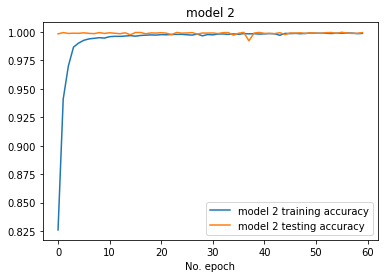

In [80]:
plt.plot(history2.history['accuracy'], label='model 2 training accuracy')
plt.plot(history2_a.history['accuracy'], label='model 2 testing accuracy')
plt.title('model 2')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
fig1 = plt.gcf()
fig1.savefig("model2.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("model2.png")
plt.show()

Model 3: Amusement vs Stress

In [5]:
respiban3 = respibans[respibans['Condition'].isin(["2","3"])]
respiban3_mini = respiban3.sample(n=600000, random_state=1)

X3 = respiban3_mini.drop("Condition", axis=1)
y3 = respiban3_mini["Condition"]
print(X3.shape, y3.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# scaling X (physiological data)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, random_state=1)
X3_scaler = MinMaxScaler().fit(X3_train)
X3_train_scaled = X3_scaler.transform(X3_train)
X3_test_scaled = X3_scaler.transform(X3_test)

# One-hot-encoding y to avoid magnitude effects
y3_train_categorical = to_categorical(y3_train)
y3_test_categorical = to_categorical(y3_test)

(600000, 6) (600000,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model3 = Sequential()
model3.add(Dense(units=12, activation='relu', input_dim=6))
model3.add(Dense(units=12, activation='relu'))
model3.add(Dense(units=12, activation='relu'))
model3.add(Dense(units=12, activation='relu'))
model3.add(Dense(units=12, activation='relu'))
model3.add(Dense(units=4, activation='softmax'))

In [13]:
#adding history object to create a graph, & increasing epochs
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(
    X3_train_scaled,
    y3_train_categorical,
    epochs=40,
    shuffle=True,
    verbose=0
)

history3_a = model3.fit(
    X3_test_scaled,
    y3_test_categorical,
    epochs=40,
    shuffle=True,
    verbose=0
)

In [14]:
model_loss5, model_accuracy5= model3.evaluate(
    X3_train_scaled, y3_train_categorical, verbose=2)
print(
    f"Train - Loss: {model_loss5}, Accuracy: {model_accuracy5}")

model_loss6, model_accuracy6 = model3.evaluate(
    X3_test_scaled, y3_test_categorical, verbose=2)
print(
    f"Test - Loss: {model_loss6}, Accuracy: {model_accuracy6}")

14063/14063 - 11s - loss: 4.4434e-05 - accuracy: 1.0000
Train - Loss: 4.443406578502618e-05, Accuracy: 1.0
4688/4688 - 4s - loss: 4.1514e-05 - accuracy: 1.0000
Test - Loss: 4.151419489062391e-05, Accuracy: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

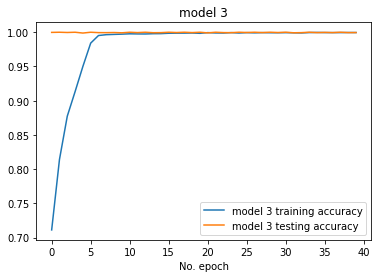

In [81]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'], label='model 3 training accuracy')
plt.plot(history3_a.history['accuracy'], label='model 3 testing accuracy')
plt.title('model 3')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
fig1 = plt.gcf()
fig1.savefig("model3.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("model3.png")
plt.show()

Model 4: Baseline vs Stress

In [19]:
#Running a two-category model to get a higher accuracy score
respiban4 = respibans[respibans['Condition'].isin(["1","2"])]
respiban4_mini = respiban4.sample(n=600000, random_state=1)
X4 = respiban4_mini.drop("Condition", axis=1)
y4 = respiban4_mini["Condition"]
print(X4.shape, y4.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# scaling X (physiological data)
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, random_state=1)
X4_scaler = MinMaxScaler().fit(X4_train)
X4_train_scaled = X4_scaler.transform(X4_train)
X4_test_scaled = X4_scaler.transform(X4_test)

# One-hot-encoding y to avoid magnitude effects
y4_train_categorical = to_categorical(y4_train)
y4_test_categorical = to_categorical(y4_test)

(600000, 6) (600000,)


In [20]:
model4 = Sequential()
model4.add(Dense(units=12, activation='relu', input_dim=6))
model4.add(Dense(units=12, activation='relu'))
model4.add(Dense(units=12, activation='relu'))
model4.add(Dense(units=12, activation='relu'))
model4.add(Dense(units=12, activation='relu'))
model4.add(Dense(units=3, activation='softmax'))

In [21]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(
    X4_train_scaled,
    y4_train_categorical,
    epochs=40,
    shuffle=True,
    verbose=0
)

history4_a = model4.fit(
    X4_test_scaled,
    y4_test_categorical,
    epochs=40,
    shuffle=True,
    verbose=0
)

In [22]:
model_loss7, model_accuracy7 = model4.evaluate(
    X4_train_scaled, y4_train_categorical, verbose=2)
print(
    f"Train - Loss: {model_loss7}, Accuracy: {model_accuracy7}")

model_loss8, model_accuracy8 = model4.evaluate(
    X4_test_scaled, y4_test_categorical, verbose=2)
print(
    f"Test - Loss: {model_loss8}, Accuracy: {model_accuracy8}")

14063/14063 - 11s - loss: 0.0018 - accuracy: 0.9999
Train - Loss: 0.001755035831592977, Accuracy: 0.9999088644981384
4688/4688 - 4s - loss: 0.0013 - accuracy: 0.9999
Test - Loss: 0.0013239870313555002, Accuracy: 0.9999133348464966


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

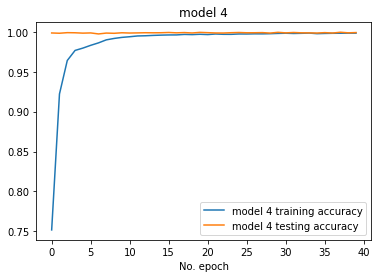

In [85]:
plt.plot(history4.history['accuracy'], label='model 4 training accuracy')
plt.plot(history4_a.history['accuracy'], label='model 4 testing accuracy')
plt.title('model 4')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
fig4 = plt.gcf()
fig4.savefig("model4.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("model4.png")
plt.show()

Plotting Subjects

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

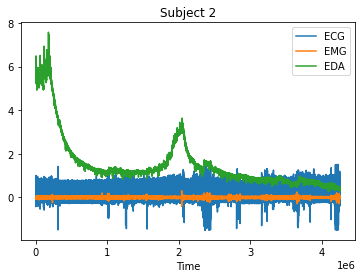

In [63]:
#used the lengths of each individual subject file
S2 = respibans.iloc[0:4255300]
S3 = respibans.iloc[4255301:4255300+4545100]
S4 = respibans.iloc[4255300+4545100:4255300+4545100+4496100]
S5 = respibans.iloc[4255300+4545100+4496100:4255300+4545100+4496100+4380600]
S6 = respibans.iloc[4255300+4545100+4496100+4380600:4255300+4545100+4496100+4380600+4949700]

from google.colab import files
plt.plot(S2['ECG'], label='ECG')
plt.plot(S2['EMG'], label='EMG')
plt.plot(S2['EDA'], label='EDA')

fig1 = plt.gcf()
plt.title('Subject 2')
plt.xlabel('Time')
plt.legend(loc="upper right")
fig1.savefig("2.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("2.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

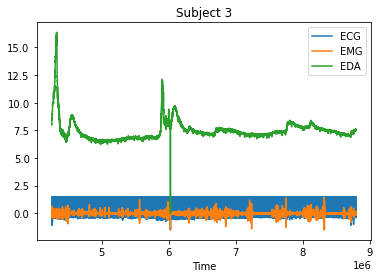

In [64]:
plt.plot(S3['ECG'], label='ECG')
plt.plot(S3['EMG'], label='EMG')
plt.plot(S3['EDA'], label='EDA')

fig1 = plt.gcf()
plt.title('Subject 3')
plt.xlabel('Time')
plt.legend(loc="upper right")
fig1.savefig("3.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("3.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

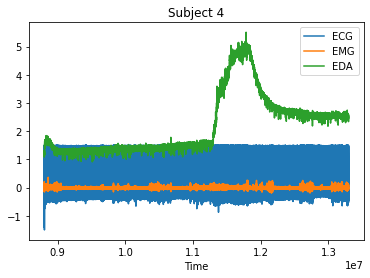

In [65]:
plt.plot(S4['ECG'], label='ECG')
plt.plot(S4['EMG'], label='EMG')
plt.plot(S4['EDA'], label='EDA')

fig1 = plt.gcf()
plt.title('Subject 4')
plt.xlabel('Time')
plt.legend(loc="upper right")
fig1.savefig("4.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("4.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

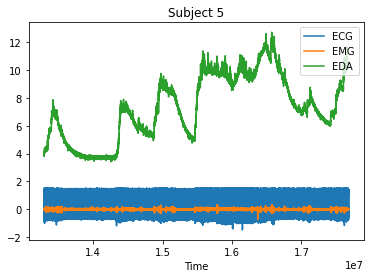

In [66]:
plt.plot(S5['ECG'], label='ECG')
plt.plot(S5['EMG'], label='EMG')
plt.plot(S5['EDA'], label='EDA')

fig1 = plt.gcf()
plt.title('Subject 5')
plt.xlabel('Time')
plt.legend(loc="upper right")
fig1.savefig("5.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("5.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

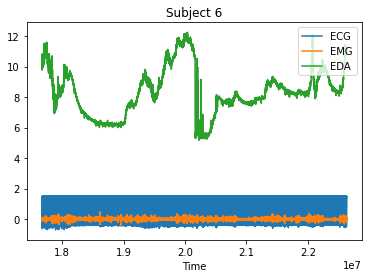

In [67]:
plt.plot(S6['ECG'], label='ECG')
plt.plot(S6['EMG'], label='EMG')
plt.plot(S6['EDA'], label='EDA')

fig1 = plt.gcf()

plt.title('Subject 6')
plt.xlabel('Time')
plt.legend(loc="upper right")
# figure(num=None)
fig1.savefig("6.png", figsize=(20, 14), dpi=200, facecolor='w', edgecolor='k')
files.download("6.png")
plt.show()